# GPT-2 for Sentiment Analysis on IMDb movie reviews

## Table of Contents
1. [Introduction](##Introduction)
2. [Data exploration](##Data-Exploration)
3. [Zero Shot Classification](##Zero-shot-classification)

## Introduction

The [IMDb](https://ai.stanford.edu/~amaas/data/sentiment/) is a binary sentiment classification dataset consisting of 100k movie reviews(50k positive and 50k negative). The dataset is split into train and test containing 50k reviews each.

In this notebook, my goals are:
1. Understand and implement [GPT-2](https://cdn.openai.com/better-language-models/language_models_are_unsupervised_multitask_learners.pdf). Run GPT-2 on the IMDb classification task.
2. Fine-tune GPT-2 for sentiment classification in under ~30 minutes on a 8GB Nvidia 1080 GTX (Faster if you have a better, newer GPU).
3. Understand how [LoRA](https://arxiv.org/abs/2106.09685) is implemented and use it to fine-tune GPT-2 for sentiment classification.

## Data-Exploration
Get a summary of the dataset. i.e
1. No of samples
2. No of positive / negative samples.
3. Length of the movie reviews



In [1]:
import sys
from pathlib import Path
# Add the parent directory to the Python path
sys.path.append(str(Path().resolve().parent))
import pandas
import torch
from torch.utils.data import Dataset

from gpt_config import GPTConfig
from reviewsDataset import reviewsDataset
from eval import Eval
from eval_config import EvalConfig
from train import Trainer
from train_config import TrainConfig
from gpt_utils import start_recording, stop_recording

In [ ]:
# Dataset exploration

imdb_train = reviewsDataset("train",max_length=10000)
imdb_test = reviewsDataset("test",max_length=10000)


def format_data(dataset: Dataset) -> pandas.DataFrame:

    data = []
    for batch in dataset:
        data.append({"input_ids":len(batch["input_ids"]),
                    "label": batch["label"],
                    "filename": batch["fpath"]})
    
    return pandas.DataFrame(data)

train_data = format_data(imdb_train)
test_data = format_data(imdb_test)


*Summary statistics of the dataset*

In [ ]:
def summary(data: pandas.DataFrame) -> None:
    print(f"Number of reviews: {len(data)}")
    print(f"Positive Reviews: {data[data['label'] == 1]['label'].count()}")
    print(f"Negative Reviews: {data[data['label'] == 0]['label'].count()}")
    print(f"Max Review Length: {data['input_ids'].max()}\nMin Review Length: {data['input_ids'].min()}")
    print(f"Median Review Length: {data['input_ids'].median()}\nMean Review Length: {data['input_ids'].mean()}")

print("Train\n--------------")
summary(train_data)
print("Test\n---------------")
summary(test_data)

*Length of reviews (measured by the number of tokens)*

In [ ]:
from matplotlib import pyplot as plt
def plot_hist(title: str,df: pandas.DataFrame) -> None:
    plt.figure()
    plt.hist(df["input_ids"],bins=100)
    plt.xlabel("No of tokens")
    plt.ylabel("Count")
    plt.title(f"{title}")

plot_hist(title='Train Data', df=train_data) 
plot_hist(title="Test Data", df=test_data)   

In [ ]:
plot_hist(title="Positive Reviews Test",df=test_data[test_data['label']==1])
plot_hist(title="Negative Reviews Test",df=test_data[test_data['label']==0])

Run the test.py in `sentiment_classification` and write the results to a file

In [ ]:
def get_metrics_by_bin(results, bins,threshold=0.5):
    TP = len(results[(results["label"] >= threshold) & (results["prediction"] >= threshold)])
    FP = len(results[(results["label"] < threshold) & (results["prediction"] >= threshold)])
    TN = len(results[(results["label"] < threshold) & (results["prediction"] < threshold)])
    FN = len(results[(results["label"] > threshold) & (results["prediction"] < threshold)])
    
    print("Metrics")
    precision = TP/(TP+FP)
    recall = TP/(TP+FN)
    accuracy = (TP+TN)/(TP+TN+FP+FN)
    print(f"Precision: {precision}\nRecall: {recall}\nAccuracy: {accuracy}")
    results["bin"] = pandas.cut(results['length'],bins)
    metrics_by_bin = results.groupby('bin').apply(lambda x: pandas.Series({"TP": ((x["label"] >= threshold) & (x["prediction"] >= threshold)).sum(),
                                                                            "FP":((x["label"] < threshold) & (x["prediction"] >= threshold)).sum(),
                                                                            "FN": ((x["label"] >= threshold) & (x["prediction"] < threshold)).sum(),
                                                                            "TN": ((x["label"] < threshold) & (x["prediction"] < threshold)).sum()}))

    metrics_by_bin["accuracy"] = (metrics_by_bin["TP"] + metrics_by_bin["TN"])/(metrics_by_bin["TP"] + metrics_by_bin["TN"]+ metrics_by_bin["FP"]+ metrics_by_bin["FN"])
    metrics_by_bin["precision"] = metrics_by_bin["TP"]/(metrics_by_bin["TP"] + metrics_by_bin["FP"])
    metrics_by_bin["recall"] = metrics_by_bin["TP"]/(metrics_by_bin["TP"] + metrics_by_bin["FN"])
    print("Metrics by bin")
    print(metrics_by_bin.to_markdown())
    return {"precision":precision,"recall":recall,"accuracy":accuracy}

## Zero Shot

### Predict the next word given the following prompt
 
Review: {review} Sentiment:

I calculate the probabilities of the word " Positive" and " Negative" and classify the review based on which probability is greater.

**Run evaluation for the zero shot approach**

In [ ]:
start_recording("gpu_memory_log.txt")
model_config = GPTConfig(block_size=256,use_lora=False)
eval_config = EvalConfig(results_path="zero_shot_256.txt",subset=True,batch_size=128)
test_set = reviewsDataset(split="test",max_length=model_config.block_size)
evaluator = Eval(test_set=test_set,eval_config=eval_config,model_config=model_config)
evaluator.evaluate()
stop_recording()


In [ ]:
res_file = pandas.read_csv("zero_shot_256.txt")
bins = range(0,1500,256)
get_metrics_by_bin(res_file,bins,threshold=0.5)

**Finetuning without LoRA**

In [2]:
start_recording("without_lora.txt")
train_config = TrainConfig(out_dir="run/10_layer_freeze/",init_from="gpt2",checkpoint_name="finetune_no_lora.ckpt")
model_config = GPTConfig(use_lora=False,block_size=256,binary_classification_head=True)
rd = reviewsDataset(split="train",max_length=model_config.block_size)
train_set, val_set = torch.utils.data.random_split(rd,[0.85,0.15])
trainer = Trainer(train_set,val_set,train_config,model_config)
trainer.train()
stop_recording()

/home/varun/projects/experiments-with-gpt2/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Loading pre-trained weights for gpt2
Number of parameters: 123.65M
num decayed parameter tensors: 9, with 14,156,544 parameters
num non-decayed parameter tensors: 19, with 21,505 parameters


  0%|          | 3/60000 [00:06<26:34:04,  1.59s/it]

Step: 0
 Train Loss: 1.3199241161346436
Validation Loss: 1.3183265924453735


  3%|▎         | 1998/60000 [01:26<38:59, 24.80it/s]

Step: 2000
 Train Loss: 0.7388057112693787
Validation Loss: 0.7314255237579346
Saving checkpoint to run/10_layer_freeze/finetune_no_lora.ckpt


  7%|▋         | 4000/60000 [02:54<38:55, 23.98it/s]   

Step: 4000
 Train Loss: 0.2787182927131653
Validation Loss: 0.2372196614742279
Saving checkpoint to run/10_layer_freeze/finetune_no_lora.ckpt


  8%|▊         | 4893/60000 [03:39<41:06, 22.34it/s]   


KeyboardInterrupt: 

**Run eval using the fine-tuned model**

In [ ]:
model_config = GPTConfig(block_size=256,use_lora=False,load_from_checkpoint=True,binary_classification_head=True,checkpoint_path="run/10_layer_freeze/finetune_no_lora.ckpt")
eval_config = EvalConfig(results_path="finetuned_no_lora.txt",subset=False)
test_set = reviewsDataset(split="test",cache_dir="/home/varun/Downloads/aclImdb/",max_length=256)
evaluator = Eval(test_set=test_set,eval_config=eval_config,model_config=model_config)
evaluator.evaluate()

**Test the performance of the fine-tuned model**

In [ ]:
res_file = pandas.read_csv("finetuned_no_lora.txt")
bins = range(0,1500,256)
get_metrics_by_bin(res_file,bins,threshold=0.5)

**Run training using LoRA**

In [4]:
start_recording("with_lora.txt")
train_config = TrainConfig(out_dir="run/10_layer_freeze_lora",
                            checkpoint_name="finetune_lora.ckpt",
                            init_from="gpt2")
model_config = GPTConfig(block_size=256,
                        use_lora=True,
                        r=8,
                        lora_layers=(10,11),
                        binary_classification_head=True)
rd = reviewsDataset(split="train",max_length=model_config.block_size,cache_dir="/home/varun/Downloads/aclImdb/")
train_set, val_set = torch.utils.data.random_split(rd,[0.85,0.15])
trainer = Trainer(train_set,val_set,train_config,model_config)
trainer.train()
stop_recording()

Loading pre-trained weights for gpt2
Number of parameters: 123.65M
num decayed parameter tensors: 5, with 49,920 parameters
num non-decayed parameter tensors: 0, with 0 parameters


  0%|          | 4/40000 [00:06<13:34:58,  1.22s/it]

Step: 0
 Train Loss: 1.3143283128738403
Validation Loss: 1.202756404876709


  3%|▎         | 1026/40000 [00:48<30:39, 21.19it/s]


KeyboardInterrupt: 

**Evaluate using the LoRA finetuned model**

In [ ]:

model_config = GPTConfig(load_from_checkpoint=True,checkpoint_path="run/10_layer_freeze_lora/finetune_lora.ckpt")
eval_config = EvalConfig(results_path="run/10_layer_freeze_lora/finetuned_lora.txt",batch_size=8,subset=False)
test_set = reviewsDataset(split="test",cache_dir="/home/varun/Downloads/aclImdb/",max_length=model_config.block_size)
evaluator = Eval(test_set=test_set,eval_config=eval_config,model_config=model_config)
evaluator.evaluate()

In [ ]:
res_file = pandas.read_csv("run/10_layer_freeze_lora/finetuned_lora.txt")
bins = range(0,1500,256)
results = get_metrics_by_bin(res_file,bins,threshold=0.5)


/tmp/ipykernel_246488/1019155924.py:6: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  data = pd.read_csv(log_file, names=["timestamp", "memory"], sep=", ")


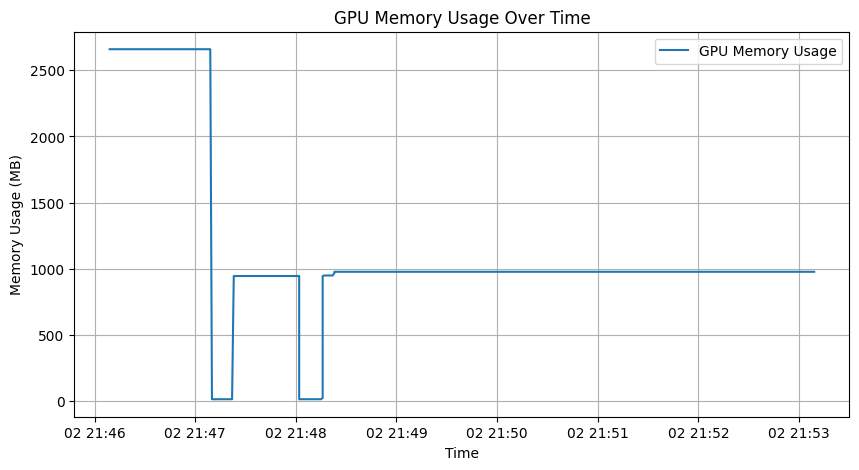

In [3]:
import pandas as pd

# Load data
log_file = "with_lora.txt"
data = pd.read_csv(log_file, names=["timestamp", "memory"], sep=", ")
data["memory"] = data["memory"].str.replace(" MiB", "").astype(int)

# Plot memory usage
plt.figure(figsize=(10, 5))
plt.plot(pd.to_datetime(data["timestamp"]), data["memory"], label="GPU Memory Usage")
plt.xlabel("Time")
plt.ylabel("Memory Usage (MB)")
plt.title("GPU Memory Usage Over Time")
plt.legend()
plt.grid(True)
plt.show()
